In [1]:
import os
import dask.array as da
import networkx as nx
import numpy as np
import zarr
from epynet import Network

import sys
sys.path.insert(0, os.path.join('..', 'utils'))
from graph_utils import get_nx_graph
from DataReader import DataReader

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
wds_id = 'ctown'

In [3]:
path_to_data = os.path.join('..', 'data', 'db_'+wds_id+'_doe_pumpfed_1')
path_to_wds = os.path.join('..', 'water_networks', wds_id+'.inp')

# Loading data
### Loading graph

In [4]:
wds = Network(path_to_wds)
G_unweighted = get_nx_graph(wds, mode='binary')
L_unweighted = da.array(nx.linalg.laplacianmatrix.laplacian_matrix(G_unweighted).todense())
L_unweighted_normalized = da.array(nx.linalg.laplacianmatrix.normalized_laplacian_matrix(G_unweighted).todense())
G_weighted = get_nx_graph(wds, mode='weighted')
L_weighted = da.array(nx.linalg.laplacianmatrix.laplacian_matrix(G_weighted).todense())
L_weighted_normalized = da.array(nx.linalg.laplacianmatrix.normalized_laplacian_matrix(G_weighted).todense())

### Loading signal

In [5]:
# Complete data
# store = zarr.open(path_to_data, mode='r')
# X = da.from_zarr(store['trn/junc_heads']).T

# Parted data: observed/unobserved
reader = DataReader(path_to_data, n_junc=len(wds.junctions.uid), obsrat=.2, seed=None)
X_complete, _, _ = reader.read_data(
    dataset = 'tst',
    varname = 'junc_heads',
    rescale = None,
    cover = False
)
X_sparse, _, _ = reader.read_data(
    dataset = 'tst',
    varname = 'junc_heads',
    rescale = None,
    cover = True
)

In [6]:
L_unweighted

dask.array<array, shape=(388, 388), dtype=float64, chunksize=(388, 388), chunktype=numpy.matrix>

In [7]:
L_weighted

dask.array<array, shape=(388, 388), dtype=float64, chunksize=(388, 388), chunktype=numpy.matrix>

In [8]:
print(X_complete.shape)
print(X_sparse.shape)

(2000, 388, 1)
(2000, 388, 2)


# Graph signal processing
### Smoothness

In [9]:
X = X_complete[:,:,0].T
smoothness_unweighted = da.dot(X.T, da.dot(L_unweighted, X)).trace()
smoothness_weighted = da.dot(X.T, da.dot(L_weighted, X)).trace()

In [10]:
print('Smoothness with unweighted Laplacian: {:.0f}.'.format(smoothness_unweighted.compute()))
print('Smoothness with weighted Laplacian: {:.0f}.'.format(smoothness_weighted.compute()))

Smoothness with unweighted Laplacian: 1595729449.
Smoothness with weighted Laplacian: 84401454.


### Spectrum

In [11]:
eigvals_weighted = np.linalg.eigvals(L_weighted_normalized.compute()).real
eigvals_unweighted = np.linalg.eigvals(L_unweighted_normalized.compute()).real

<BarContainer object of 388 artists>

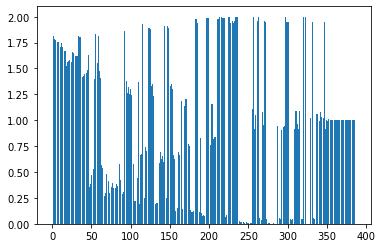

In [12]:
plt.bar(np.arange(len(eigvals_weighted)), eigvals_weighted)

<BarContainer object of 388 artists>

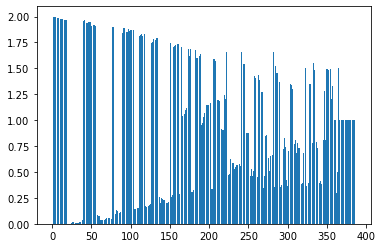

In [13]:
plt.bar(np.arange(len(eigvals_weighted)), eigvals_unweighted)

# Signal reconstruction
### Getting S: rearranging the Laplacian

In [14]:
S = np.array(L_unweighted)
F = X_sparse[:,:,0].copy()
X_reconstructed = X_sparse[:,:,0].copy()
flag_observed = X_sparse[:,:,1][0,:]

In [15]:
insert_idx = 0
for i, flag in enumerate(flag_observed):
    if flag:
        observed_col = np.copy(S[:,i])
        S[:,i] = S[:,insert_idx]
        S[:,insert_idx] = observed_col
        
        S[i,:] = S[insert_idx,:]
        S[insert_idx,:] = observed_col.T
        
        observed_col = np.copy(F[:,i])
        F[:,i] = F[:,insert_idx]
        F[:,insert_idx] = observed_col
        
        insert_idx += 1

In [16]:
F = F[:,:insert_idx]
S_2 = S[:insert_idx, insert_idx:]
S_3 = S[insert_idx:, insert_idx:]
try:
    S_3_inv = np.linalg.inv(S_3)
except:
    S_3_inv = np.linalg.pinv(S_3)

In [17]:
F_hat = -np.dot(S_3_inv, np.dot(S_2.T, F.T)).T

In [18]:
insert_idx = 0
for i, flag in enumerate(flag_observed):
    if not flag:
        X_reconstructed[:,i] = F_hat[:,insert_idx]
        insert_idx += 1

In [19]:
X_reconstructed[0,:]

array([-2.85830612e+02,  6.82715683e+01,  7.42842712e+01, -9.19964075e+02,
       -1.59667240e+00, -3.45893483e+01, -4.08995582e+02, -4.84877669e+02,
       -1.65168415e+02,  6.81660461e+01,  1.22750519e+02,  1.22750519e+02,
        7.00110189e+01,  7.78931885e+01, -5.99164905e+02, -4.49335230e+02,
       -4.49335230e+02,  1.21602797e+02,  7.79711990e+01,  1.21602797e+02,
       -5.30239623e+02, -2.54069265e+03,  1.34314041e+02,  1.18031151e+02,
        9.74203568e+01,  6.98733749e+01,  8.17135345e+01,  6.93183710e+01,
        1.25886980e+02,  1.05293470e+02,  1.12453764e+02, -2.14615751e+03,
        1.79847977e+02,  7.62556305e+01,  1.82328110e+02,  1.09489247e+02,
        1.09009217e+02,  1.22594329e+02,  1.23911385e+02,  1.30194556e+02,
        1.23872208e+02,  1.23869141e+02,  1.08529187e+02, -9.50053248e+01,
        1.56189667e+02,  1.07392524e+02,  1.15515208e+02,  1.17991539e+02,
        1.07963501e+02, -8.32531740e+02, -8.32531740e+02, -1.08672862e+03,
       -6.09399888e+02,  

In [20]:
X_sparse[0,:,0]

array([  0.        ,   0.        ,  74.28427124,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,  77.89318848,   0.        ,   0.        ,
         0.        ,   0.        ,  77.97119904,   0.        ,
         0.        ,   0.        ,   0.        , 118.03115082,
        97.42035675,  69.87337494,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
       179.84797668,  76.25563049, 182.32810974,   0.        ,
         0.        ,   0.        , 123.91138458,   0.        ,
       123.87220764, 123.86914062,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        , 117.991539  ,
       107.96350098,   0.        ,   0.        ,   0.        ,
         0.        , 108.87785339,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        , 113.34528351,
         0.        ,   0.        ,  78.66578674,   0.  

In [21]:
X[:,0]

array([136.26605 ,  81.91984 ,  74.28427 , 211.05664 , 182.46265 ,
        71.731155,  70.47443 ,  70.09612 , 120.78047 , 120.79069 ,
       112.45797 , 112.45499 ,  77.93689 ,  77.89319 ,  77.764275,
       117.140335, 117.1397  ,  77.985794,  77.9712  ,  78.0079  ,
        78.83949 ,  76.75415 ,  77.99275 , 118.03115 ,  97.42036 ,
        69.873375,  71.3504  ,  70.47443 ,  76.27071 ,  77.39382 ,
        77.30369 , 180.95346 , 179.84798 ,  76.25563 , 182.32811 ,
        77.14528 ,  77.77221 ,  77.84452 , 123.911385, 123.87282 ,
       123.87221 , 123.86914 ,  80.10452 , 125.0965  ,  78.30671 ,
       126.76337 , 160.7465  , 117.99154 , 107.9635  ,  77.675064,
        77.5252  , 109.379616, 109.2286  , 108.87785 , 110.15802 ,
       157.54214 , 110.352684, 157.0458  , 111.08573 , 113.34528 ,
       110.27815 , 114.215614,  78.66579 ,  78.6403  ,  79.549934,
        78.89337 ,  78.33542 ,  81.148056,  81.52261 ,  77.95057 ,
        81.62277 , 176.3363  ,  77.67446 , 118.03173 , 117.594